In my last post, I demonstrated image segmentation with the python OpenCV library to remove a product image's background. The motivation for removing the background was to prepare the image for color analysis, targeted specifically to the product itself.

In this post, I will show you how to find the dominant colors of the product image using K-Means clustering. 



## Image Flattening

Before diving into the details of our color analysis, we will need to prepare our image further. At the start, our image was a product on a white background. By using image segmentation, we were able to "cut" out the background of the image and turning the background white pixels to black. 

To perform K-Means Clustering, we must have an array of values to analyze. Unfortunately, our image is an 2D array of pixel data, or an NxM matrix. This data also includes the now black background pixels. 

To prepare the image for color analysis, we will "flatten" the image from a 2D array into a single one-dimensional array, and then delete all of the black background pixels. 

In [1]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from collections import Counter

In [2]:
def remove_pixels(np_array, rgb_color=[0,0,0]):
    # flatten into array of [r,g,b] values
    colors_list = np.reshape(np_array, (-1,3)) # -1 is unspecified
    less_color = np.delete(colors_list, np.argwhere(colors_list == rgb_color), axis=0) # remove specified [r,g,b]

    return less_color # 1D array of product pixels

## K-Means Clustering

With that taken care of, we can now dive into the color analysis.

In [23]:
def rgb_to_hex(rgb_color):
    hex_color = "#"
    for i in rgb_color:
        hex_color += ("{:02x}".format( int(i) ))
    return hex_color

def hex_to_rgb(hex_color):
    color = hex_color.lstrip('#')
    lv = len(color)
    return tuple(int(color[i:i+lv//3], 16) for i in range(0, lv, lv//3))

def color_analysis(img):
    clf = KMeans(n_clusters = 5) # Show us the 5 most dominant colors
    color_labels = clf.fit_predict(img) # Analyze this image
    center_colors = clf.cluster_centers_
    
    counts = Counter(color_labels) # Count frequency of dominant colors
    ordered_colors = [center_colors[i] for i in counts.keys()] # Sort by "dominance" of that color
    hex_colors = [rgb_to_hex(ordered_colors[i]) for i in counts.keys()] # Convert to hex values

    return counts, hex_colors

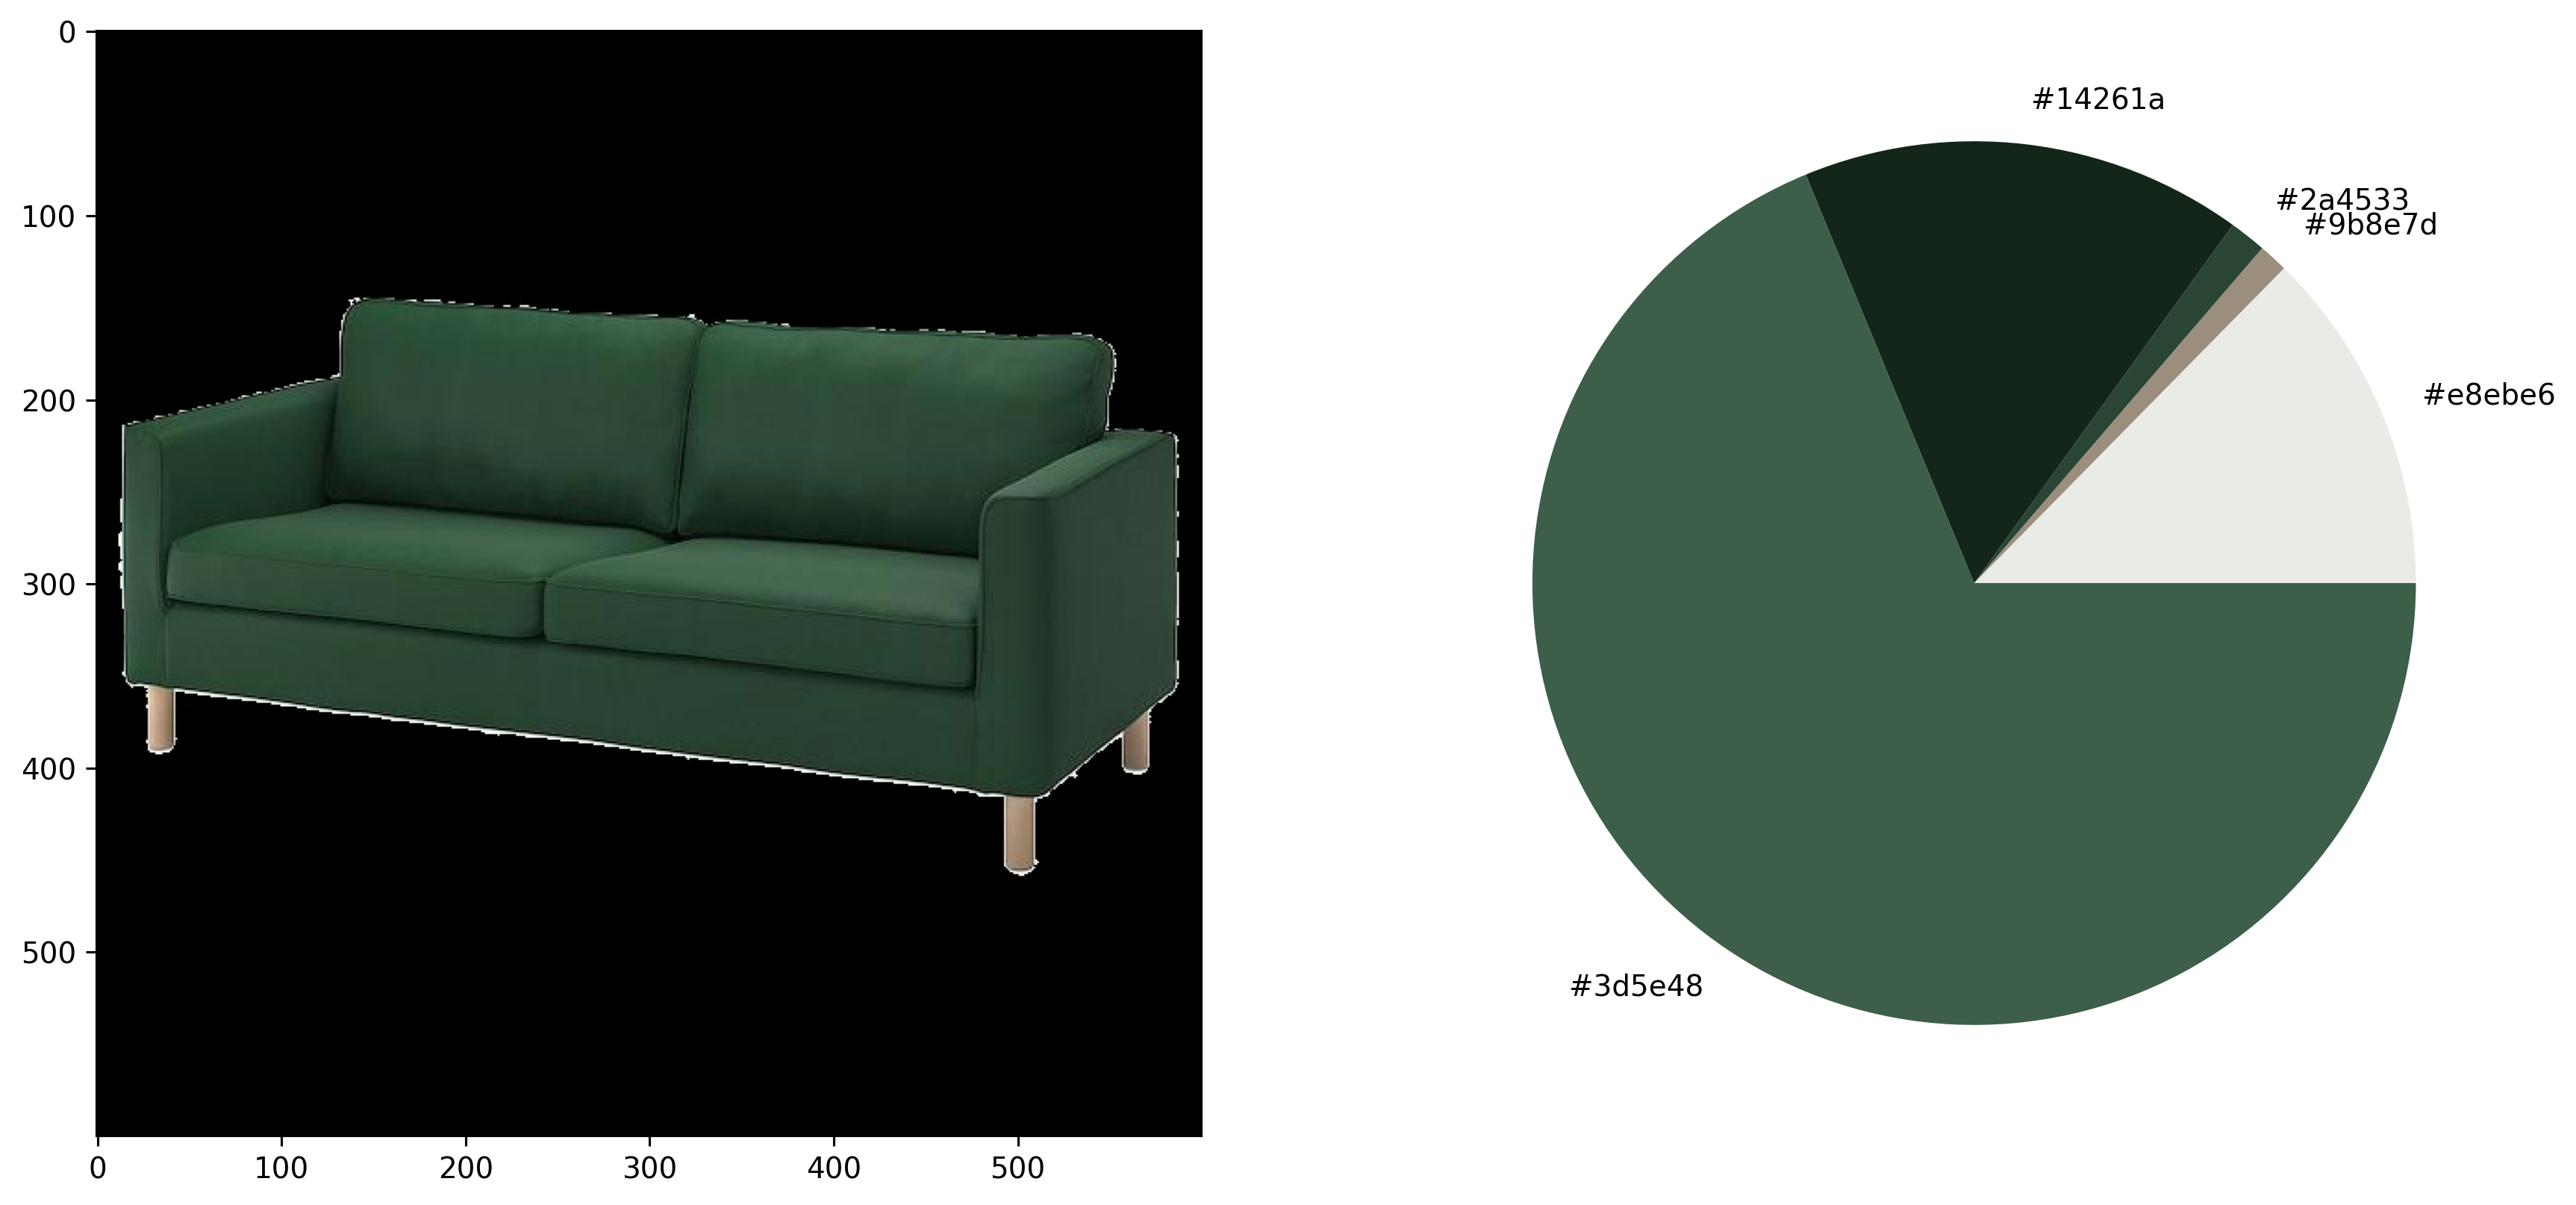

In [27]:
img_path = './green-couch-segmented.jpg'
only_product = cv2.imread(img_path)

flat_array = remove_pixels(only_product) # Turn image into an array
counts, hex_colors = color_analysis(flat_array)  # Run color analysis on identified product image

# Just to show the images!
fig = plt.figure(figsize=(15,15), dpi=280)
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.imshow(only_product) 
ax2.pie(counts.values(), labels = hex_colors, colors = hex_colors)
plt.show()

### First Results
How amazing! All of the colors present in this image seem to be well represented. It even has the color of the feet!

However, there are some big limitations to this approach. In an interactive version of this code, you can see that the values of this pie chart change dramatically on consecutive runs. In some cases, we even see the off-white section take up the majority of the pie chart.

Obviously, this is wrong. We want our tool to not only identify the main colors of the product, we want it to also reflect approximately *how much* of the product is represented by each color. Sure, the feet of the sofa are a lighter wood, but nobody would describe this as a "tan couch". 

We need to refine this approach further.

## Limitations

Naturally, the first approach is rarely the best. What can be improved about our analysis? And why does the K-Means clustering sometimes tell us that the main color is tan?

### Visualizing Color Spaces

In the first post on this tool, I decided that I was going to use the normal RGB colorspace to represent the colors of our image numerically. Why? Well, because its the most common. But is it the best?

When I was first developing this code, I noticed that sometimes it would give a *very* wrong answer. I wanted to look into this further to determine the source of this variability.

My first thought was to try to visualize what was happening with the K-Means clustering to try to debug it. I wrote a few methods to map the RGB values from each pixel's colors into 3D space. I wanted to see what the clustering actually looked like to try to understand what might be going wrong.

In [52]:
def get_kmeans(array, clusters=3):
    clstdata = {}
    clf = KMeans(n_clusters = clusters)
    
    clstdata['input'] = array
    clstdata['cluster'] = clf.fit_predict(array)
    clstdata['center_colors'] = clf.cluster_centers_
    return clstdata
    
def kmeans_3d(clstdata, ax):
    # https://towardsdatascience.com/visualizing-clusters-with-pythons-matplolib-35ae03d87489
    # counts = Counter(clstdata['cluster'])
    # ordered_colors = [clstdata['center_colors'][i] for i in counts.keys()]
    # hex_colors = [ rgb_to_hex(ordered_colors[rgb]) for rgb in clstdata['center_colors'] ]
    hex_colors = [ rgb_to_hex(rgb) for rgb in clstdata['center_colors'] ]
    clstdata['c'] = [ hex_colors[i] for i in clstdata['cluster'] ]
    
    flat_array = clstdata['input']
    r = flat_array[ :,0]
    g = flat_array[ :,1]
    b = flat_array[ :,2]

    ax.scatter(r,g,b, c=clstdata['c'])
    
    ax.set_xlabel('Red')
    ax.set_ylabel('Green')
    ax.set_zlabel('Blue')
    ax.set_title('Clustered Colors')

def kmeans_3d_color_rep(clstdata, ax):
    clstdata['c'] = [ rgb_to_hex(rgb) for rgb in clstdata['input'] ]
    
    flat_array = clstdata['input']
    r = flat_array[ :,0]
    g = flat_array[ :,1]
    b = flat_array[ :,2]

    ax.scatter(r,g,b, c=clstdata['c'], alpha=0.4)
    
    ax.set_xlabel('Red')
    ax.set_ylabel('Green')
    ax.set_zlabel('Blue')
    ax.set_title('KMeans with Pixel Colors')

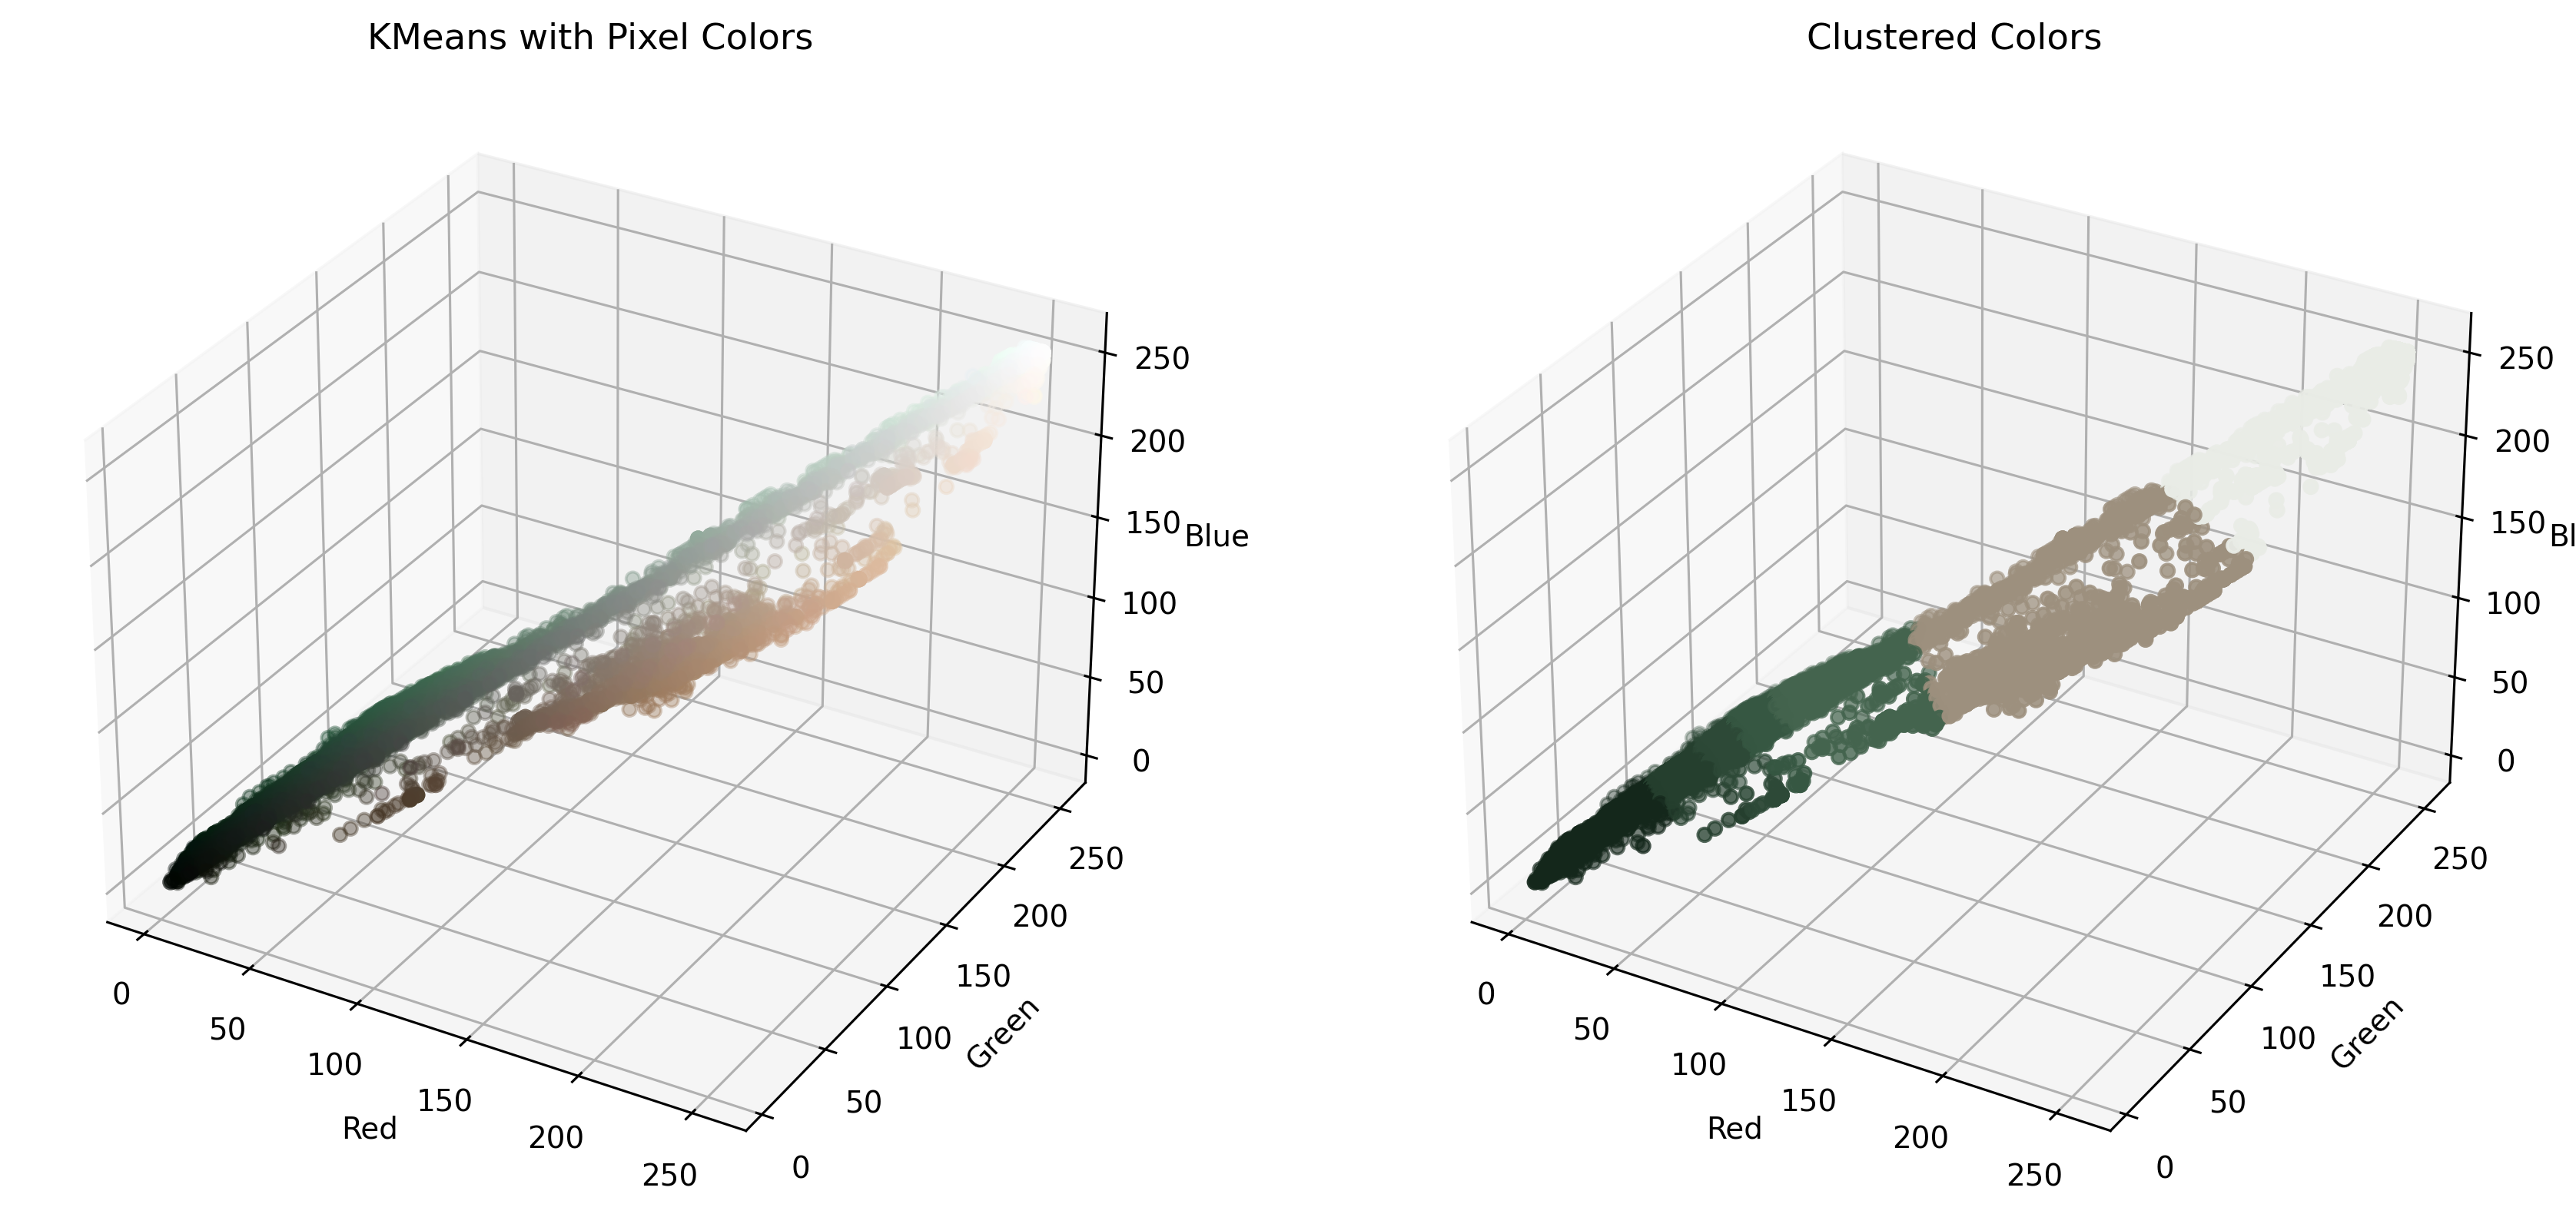

In [53]:
cluster_data = get_kmeans(flat_array, 7)

fig = plt.figure(figsize=(15,15), dpi=280)
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

kmeans_3d_color_rep(cluster_data, ax1)
kmeans_3d(cluster_data, ax2)

plt.show()

### Observations



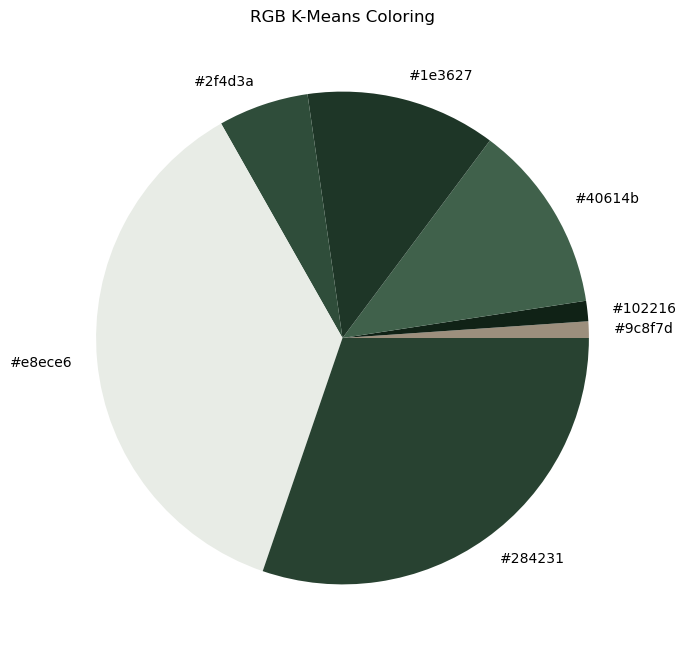

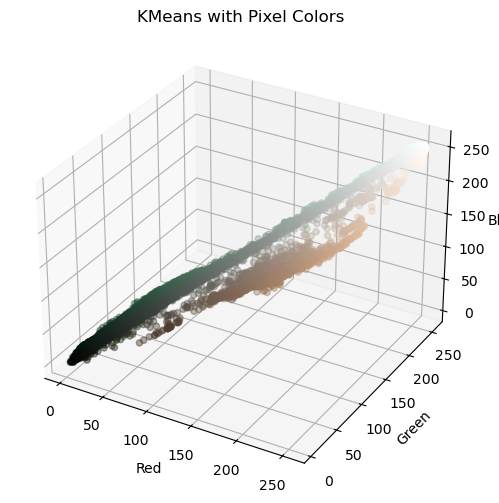

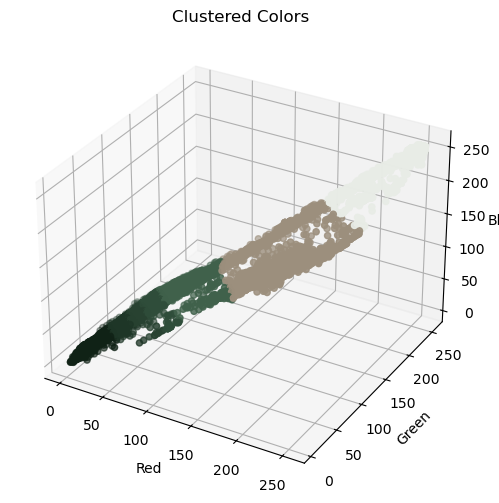

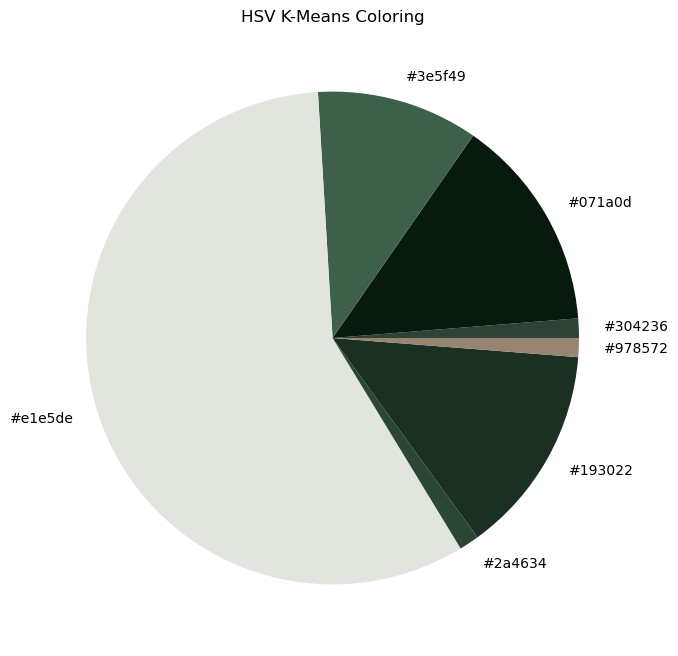

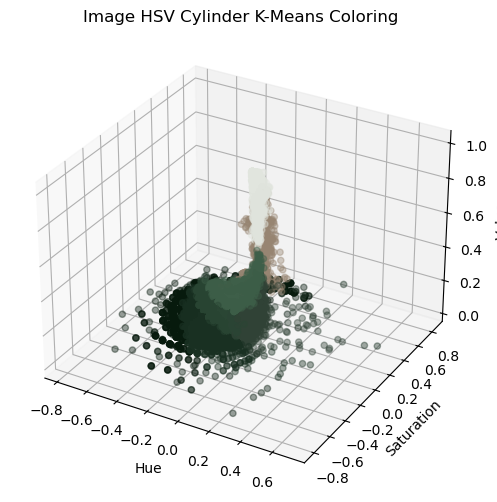

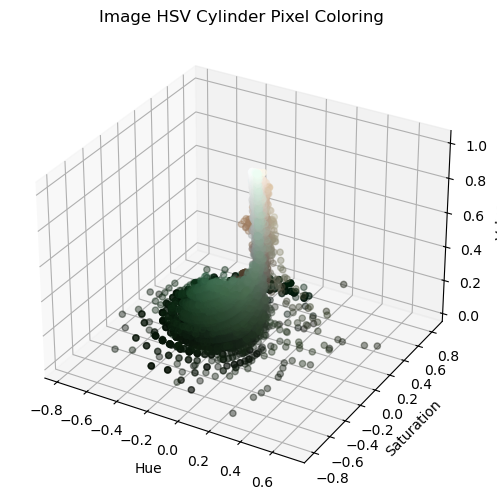

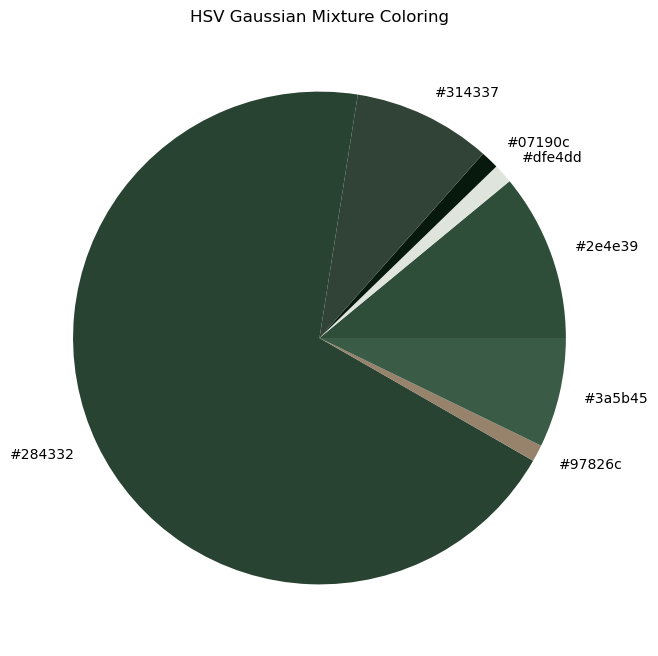

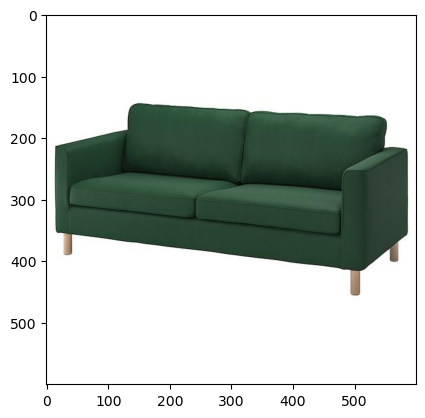

In [55]:
# -*- coding: utf-8 -*-
"""
Created on Fri Dec 30 15:49:08 2022

@author: Kellan Cerveny

Resources:
    https://towardsdatascience.com/visualizing-clusters-with-pythons-matplolib-35ae03d87489
    https://medium.com/analytics-vidhya/color-separation-in-an-image-using-kmeans-clustering-using-python-f994fa398454
    https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html
    https://scikit-learn.org/stable/modules/mixture.html#gmm
    http://www.cse.msu.edu/~pramanik/research/papers/2002Papers/icip.hsv.pdf
    https://en.wikipedia.org/wiki/HSL_and_HSV#Color_conversion_formulae

"""
import cv2
from matplotlib import pyplot as plt
import matplotlib.colors
import numpy as np
import os
import random
from collections import Counter
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from skimage.color import rgb2hsv, hsv2rgb
from sklearn.model_selection import GridSearchCV

import pandas as pd
import seaborn as sns

def rgb_to_hex(rgb_color):
    hex_color = "#"
    for i in rgb_color:
        i = int(i)
        hex_color += ("{:02x}".format(i))
    return hex_color

def hex_to_rgb(hex_color):
    color = hex_color.lstrip('#')
    lv = len(color)
    return tuple(int(color[i:i+lv//3], 16) for i in range(0, lv, lv//3))

def color_analysis(clstdata):
    counts = Counter(clstdata['cluster'])
    ordered_colors = [clstdata['center_colors'][i] for i in counts.keys()]
    hex_colors = [rgb_to_hex(ordered_colors[i]) for i in counts.keys()]
    ax = plt.figure(figsize = (12, 8))
    plt.pie(counts.values(), labels = hex_colors, colors = hex_colors)
    #plt.savefig("color_analysis_report.png")
    
    plt.title('RGB K-Means Coloring')
    plt.show()
    
def remove_pixels(np_array, rgb_color=[0,0,0]):
    # flatten into array of [r,g,b] values
    colors_list = np.reshape(np_array, (-1,3)) # -1 is unspecified
    less_color = np.delete(colors_list, np.argwhere(colors_list == rgb_color), axis=0) # remove specified [r,g,b]

    return less_color

def remove_white(img,thresh=250):
    src = cv2.imread(img)
    rgb = cv2.cvtColor(src, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY) # convert RGB to grayscale

    th, im_th = cv2.threshold(gray, thresh, 255, cv2.THRESH_BINARY_INV);
    white_bg = cv2.morphologyEx(im_th, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,2)))
    # black_bg = cv2.bitwise_not(white_bg) # invert mask

    im_out = cv2.bitwise_and(rgb,rgb, mask=white_bg)

#    print('{},{}'.format(type(im_out), im_out))
    return im_out


def get_kmeans(array, clusters=3):
    clstdata = {}
    clf = KMeans(n_clusters = clusters)
    
    clstdata['input'] = array
    clstdata['cluster'] = clf.fit_predict(array)
    clstdata['center_colors'] = clf.cluster_centers_
    return clstdata

def get_gaussian_mixture(array, clusters=4, cov_type='spherical'):
    clsdata = {}
    mix = GaussianMixture(n_components=clusters, covariance_type=cov_type, max_iter=20, random_state=0)

    clsdata['input'] = array
    clsdata['cluster'] = mix.fit_predict(array)
    clsdata['means'] = mix.means_
    clsdata['weights'] = mix.weights_
    
    return clsdata

def gmm_bic_score(estimator, X):
    """Callable to pass to GridSearchCV that will use the BIC score."""
    # Make it negative since GridSearchCV expects a score to maximize
    return -estimator.bic(X)

def gmm_model_selection(input_array):
    param_grid = {
        "n_components": range(3, 7),
        "covariance_type": ["spherical", "tied", "diag"],
    }
    
    grid_search = GridSearchCV(GaussianMixture(), param_grid=param_grid, scoring=gmm_bic_score)
    grid_search.fit(input_array)
    return grid_search

def plot_gmm_selection(grid_search):
    df = pd.DataFrame(grid_search.cv_results_)[
        ["param_n_components", "param_covariance_type", "mean_test_score"]
    ]
    df["mean_test_score"] = -df["mean_test_score"]
    df = df.rename(
        columns={
            "param_n_components": "Number of components",
            "param_covariance_type": "Type of covariance",
            "mean_test_score": "BIC score",
        }
    )
    df.sort_values(by="BIC score").head()
    
    sns.catplot(data=df,kind="bar",x="Number of components",y="BIC score",hue="Type of covariance",)
    plt.show()

def kmeans_3d(clstdata):
    # https://towardsdatascience.com/visualizing-clusters-with-pythons-matplolib-35ae03d87489
    # counts = Counter(clstdata['cluster'])
    # ordered_colors = [clstdata['center_colors'][i] for i in counts.keys()]
    # hex_colors = [ rgb_to_hex(ordered_colors[rgb]) for rgb in clstdata['center_colors'] ]
    hex_colors = [ rgb_to_hex(rgb) for rgb in clstdata['center_colors'] ]
    clstdata['c'] = [ hex_colors[i] for i in clstdata['cluster'] ]
    
    flat_array = clstdata['input']
    r = flat_array[ :,0]
    g = flat_array[ :,1]
    b = flat_array[ :,2]

    fig = plt.figure(figsize=(26,6))
    ax = fig.add_subplot(projection='3d')
    ax.scatter(r,g,b, c=clstdata['c'])
    
    ax.set_xlabel('Red')
    ax.set_ylabel('Green')
    ax.set_zlabel('Blue')
    ax.set_title('Clustered Colors')
    
    plt.show()

def kmeans_elbow(flat_array):
    inertias = []
    NUMCLUST = range(1,6)

    for i in NUMCLUST:
        kmeans = KMeans(n_clusters=i)
        kmeans.fit(flat_array)
        inertias.append(kmeans.inertia_)
    
    # fig = plt.figure(figsize=(26,6))
    plt.plot(NUMCLUST, inertias, marker='o')
    plt.title('Elbow method')
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')
    
    plt.show() 

def kmeans_3d_color_rep(clstdata):
    clstdata['c'] = [ rgb_to_hex(rgb) for rgb in clstdata['input'] ]
    
    flat_array = clstdata['input']
    r = flat_array[ :,0]
    g = flat_array[ :,1]
    b = flat_array[ :,2]

    fig = plt.figure(figsize=(26,6))
    ax = fig.add_subplot(projection='3d')
    ax.scatter(r,g,b, c=clstdata['c'], alpha=0.4)
    
    ax.set_xlabel('Red')
    ax.set_ylabel('Green')
    ax.set_zlabel('Blue')
    ax.set_title('KMeans with Pixel Colors')
    
    plt.show()

# Cylinder plotting calculations
def hsv_to_cartesian(hsv):
    H,S,V = hsv
    H = 2*np.pi*H # convert (0,1)->(0,2pi)
    
    x = S*np.cos(H) # r*cos(theta)
    y = S*np.sin(H) # r*sin(theta)
    z = V # z coord maps one-to-one
    return x,y,z

def cartesian_to_hsv(cart):
    x,y,z = cart
    
    radius = np.sqrt( x*x + y*y )
    theta = np.arctan2(y,x)
    if theta < 0:
        theta += 2*np.pi
    
    h = theta/(2*np.pi)
    s = radius
    v = z # z coord maps to value
    return h,s,v

def hsv_gaussian_analysis(clsdata):
    
    center_hsv = [cartesian_to_hsv(cart) for cart in clsdata['means'] ]
    center_hsv = np.reshape(center_hsv, (-1,3))
    center_rgb = 255*np.array(hsv2rgb(center_hsv, channel_axis=1))
    
    hex_colors = [rgb_to_hex(rgb) for rgb in center_rgb]
    plt.figure(figsize = (12, 8))
    plt.pie(clsdata['weights'], labels = hex_colors, colors = hex_colors)
    #plt.savefig("color_analysis_report.png")

    plt.title('HSV Gaussian Mixture Coloring')
    plt.show()
    

def hsv_color_analysis(clstdata):
    
    counts = Counter(clstdata['cluster'])
    ordered_colors = [clstdata['center_colors'][i] for i in counts.keys()]
    
    center_hsv = [cartesian_to_hsv(cart) for cart in ordered_colors ]
    center_hsv = np.reshape(center_hsv, (-1,3))
    center_rgb = 255*np.array(hsv2rgb(center_hsv, channel_axis=1))
    
    hex_colors = [rgb_to_hex(center_rgb[i]) for i in counts.keys()]
    plt.figure(figsize = (12, 8))
    plt.pie(counts.values(), labels = hex_colors, colors = hex_colors)
    #plt.savefig("color_analysis_report.png")

    plt.title('HSV K-Means Coloring')
    plt.show()

def hsv_3d_color_rep(clstdata, hsv_array):
    flat_hsv = [ cartesian_to_hsv(cart) for cart in clstdata['input'] ]
    flat_hsv = np.reshape(flat_hsv, (-1,3))
    flat_rgb = 255*np.array(hsv2rgb(flat_hsv, channel_axis=1))
    
    clstdata['c'] = [ rgb_to_hex(rgb) for rgb in flat_rgb ]
    
    h = hsv_array[ :,0]
    s = hsv_array[ :,1]
    v = hsv_array[ :,2]

    fig = plt.figure(figsize=(26,6))
    ax = fig.add_subplot(projection='3d')
    ax.scatter(h,s,v, c=clstdata['c'], alpha=0.4)
    
    ax.set_xlabel('Hue')
    ax.set_ylabel('Saturation')
    ax.set_zlabel('Value')
    ax.set_title('Image HSV pixel distribution')
    
    plt.show()

def hsv_kmeans_cylinder(clstdata):    
    center_hsv = [cartesian_to_hsv(cart) for cart in clstdata['center_colors'] ]
    center_hsv = np.reshape(center_hsv, (-1,3))
    center_rgb = 255*np.array(hsv2rgb(center_hsv, channel_axis=1))
    
    hex_colors = [ rgb_to_hex(rgb) for rgb in center_rgb ]
    
    clstdata['c'] = [ hex_colors[i] for i in clstdata['cluster'] ]
    
    cart = [hsv_to_cartesian(pixel) for pixel in clstdata['input']]
    cart = np.reshape(cart, (-1,3))
    X = cart[ :,0]
    Y = cart[ :,1]
    Z = cart[ :,2]

    fig = plt.figure(figsize=(26,6))
    ax = fig.add_subplot(projection='3d')
    ax.scatter(X,Y,Z, c=clstdata['c'], alpha=0.4)
    
    ax.set_xlabel('Hue')
    ax.set_ylabel('Saturation')
    ax.set_zlabel('Value')
    ax.set_title('Image HSV Cylinder K-Means Coloring')
    
    plt.show()    

def hsv_guassian_cylinder(clstdata):    
    # center_hsv = [cartesian_to_hsv(cart) for cart in clsdata['means'] ]
    # center_hsv = np.reshape(center_hsv, (-1,3))
    # center_rgb = 255*np.array(hsv2rgb(center_hsv, channel_axis=1))
    
    # hex_colors = [rgb_to_hex(rgb) for rgb in center_rgb]
    # plt.figure(figsize = (12, 8))
    # plt.pie(clsdata['weights'], labels = hex_colors, colors = hex_colors)

    center_hsv = [cartesian_to_hsv(cart) for cart in clstdata['means'] ]
    center_hsv = np.reshape(center_hsv, (-1,3))
    center_rgb = 255*np.array(hsv2rgb(center_hsv, channel_axis=1))
    
    hex_colors = [ rgb_to_hex(rgb) for rgb in center_rgb ]
    
    clstdata['c'] = [ hex_colors[i] for i in clstdata['cluster'] ]
    
    cart = [hsv_to_cartesian(pixel) for pixel in clstdata['input']]
    cart = np.reshape(cart, (-1,3))
    X = cart[ :,0]
    Y = cart[ :,1]
    Z = cart[ :,2]

    fig = plt.figure(figsize=(26,6))
    ax = fig.add_subplot(projection='3d')
    ax.scatter(X,Y,Z, c=clstdata['c'], alpha=0.4)
    
    ax.set_xlabel('Hue')
    ax.set_ylabel('Saturation')
    ax.set_zlabel('Value')
    ax.set_title('Image HSV Cylinder Gaussian Coloring')
    
    plt.show() 

def hsv_cylinder_form(clstdata):
    flat_hsv = [ cartesian_to_hsv(cart) for cart in clstdata['input'] ]
    flat_hsv = np.reshape(flat_hsv, (-1,3))
    flat_rgb = 255*np.array(hsv2rgb(flat_hsv, channel_axis=1))
    
    clstdata['c'] = [ rgb_to_hex(rgb) for rgb in flat_rgb ]
    
    # clstdata['c'] = [ rgb_to_hex(rgb) for rgb in clstdata['input'] ]
    
    cart = [hsv_to_cartesian(pixel) for pixel in clstdata['input']]
    cart = np.reshape(cart, (-1,3))
    X = cart[ :,0]
    Y = cart[ :,1]
    Z = cart[ :,2]

    fig = plt.figure(figsize=(26,6))
    ax = fig.add_subplot(projection='3d')
    ax.scatter(X,Y,Z, c=clstdata['c'], alpha=0.4)
    
    ax.set_xlabel('Hue')
    ax.set_ylabel('Saturation')
    ax.set_zlabel('Value')
    ax.set_title('Image HSV Cylinder Pixel Coloring')
    
    plt.show()

def hsv_color_circle():
    
    # 1) create line of differing saturations
    H = np.repeat([np.linspace(0, 1, 100)], 10, axis=0)
    S = np.repeat([np.linspace(0, 1, 10)], 100, axis=0).transpose()
    V = np.repeat([np.ones(100)], 10, axis=0)
    
    hsv3d = np.asarray(cv2.merge((H, S, V)))
    hsv = np.reshape(hsv3d, (-1,3))
    cart = [hsv_to_cartesian(pixel) for pixel in hsv]
    cart = np.reshape(cart, (-1,3))

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    X = cart[ :,0]
    Y = cart[ :,1]
    Z = cart[ :,2]
    
    # ax.plot_surface(X, Y, Z, facecolors=C/255.)
    ax.scatter(X,Y,Z, alpha=0.4)
    plt.show()
    return hsv


# NOTE: currently not working
def hsv_color_cylinder():
    
    # 1) create line of differing saturations
    H = np.repeat(np.repeat([np.linspace(0, 1, 100)], 10, axis=0), 10, axis=1)
    S = np.repeat(np.repeat([np.linspace(0, 1, 10)], 100, axis=0).transpose(), 10, axis=1)
    # V = np.repeat([np.repeat([np.linspace(0, 1, 100)], 10, axis=0)], 10, axis=0)
    V = np.repeat(np.repeat([np.ones(100)], 10, axis=0), 10, axis=1)
    # V = np.flip(V,2)
    
    # hsv3d = np.asarray(cv2.merge((H, S, V)))
    hsv3d = np.asarray(np.reshape((H, S, V)))
    return hsv3d
    hsv = np.reshape(hsv3d, (-1,3))
    cart = [hsv_to_cartesian(pixel) for pixel in hsv]
    cart = np.reshape(cart, (-1,3))

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    X = cart[ :,0]
    Y = cart[ :,1]
    Z = cart[ :,2]
    
    # ax.plot_surface(X, Y, Z, facecolors=C/255.)
    ax.scatter(X,Y,Z, alpha=0.4)
    plt.show()
    return hsv

# -----------------------------------------------------------------------
# Main sequence
# -----------------------------------------------------------------------
# hsv = hsv_color_circle()
# hsv = hsv_color_cylinder()

    
img = './green-sofa.jpg'
# print(img)

only_prod = remove_white(img) # converts to RGB colorspace as well
flat_array = remove_pixels(only_prod)

hsv_flat = rgb2hsv(flat_array, channel_axis=1)
cart = [hsv_to_cartesian(pixel) for pixel in hsv_flat]
cartpx = np.reshape(cart, (-1,3)) # Converting HSV to cartesian coordinates to graph

# ------ RGB Analysis ------
cluster_data = get_kmeans(flat_array, 7)
color_analysis(cluster_data)  # Run color analysis on identified product image
# # kmeans_elbow(flat_array)
kmeans_3d_color_rep(cluster_data)
kmeans_3d(cluster_data)

# ------ HSV Analysis ------
hsv_cluster = get_kmeans(cartpx, 7)
hsv_color_analysis(hsv_cluster)
hsv_kmeans_cylinder(hsv_cluster)
hsv_cylinder_form(hsv_cluster)
# # hsv_3d_color_rep(hsv_cluster, hsv_flat) # Cartesian HSV coordinates (non-polar)

hsv_gaussian = get_gaussian_mixture(cartpx, 7, cov_type='spherical')
# hsv_gaussian_analysis(hsv_gaussian)
# hsv_guassian_cylinder(hsv_gaussian)

hsv_gaussianT = get_gaussian_mixture(cartpx, 7, cov_type='tied')
hsv_gaussian_analysis(hsv_gaussianT)
# hsv_guassian_cylinder(hsv_gaussianT) # Display clustered points in 3d HSV cylinder

# ------ HSV Gaussian Mixture Model Training ------
# grid_search = gmm_model_selection(cartpx)
# plot_gmm_selection(grid_search)        

# ------ Product Image Display ------
show_img = cv2.imread(img)
img=cv2.cvtColor(show_img,cv2.COLOR_BGR2RGB)
plt.imshow(img)


